In [46]:
import numpy as np
import pandas as pd
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [47]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv', parse_dates=['TradeDateTime'])
# df = pd.read_csv('/Users/lecueguillaume/Documents/bnpp/bnpp_donnees/ETSAnonymousPricesFull.csv', parse_dates=['TradeDateTime'], index_col='TradeDateTime')

## ML for prediction

Let's try to beat the baseline. 

### Non-parametric model - K-nearest neighbors

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation

First, let's try with the normalized price as the single feature.

In [49]:
sell = df["BuySell"] == "Sell"
buy = df["BuySell"] == "Buy"
do = df["TradeStatus"] == "Done"
ta = df["TradeStatus"] == "TradedAway"
resp = df["BNPPAnsweredQuote"] > 0
ab = df["Bid2Mid"] > 0
idx = buy & (do | ta) & resp & ab
X = df.ix[idx, ["BNPPAnsweredQuote", "RFQCompositePrice", "Bid2Mid"]]
X = (X["BNPPAnsweredQuote"] - X["RFQCompositePrice"]) / np.abs(X["Bid2Mid"])
y = df.ix[idx, "TradeStatus"]

In [50]:
X.describe()

count    2.140850e+05
mean    -3.892958e+08
std      1.182511e+11
min     -4.624810e+13
25%     -7.142792e-01
50%     -8.005615e-02
75%      6.562390e-01
max      2.000080e+05
dtype: float64

In [51]:
xmin, xmax = X.quantile([.022, .9])
print xmin, xmax

-5.67566366389 5.87672519732


In [52]:
idx  = (X > xmin) & (X < xmax)
X = np.array([X.ix[idx]]).T
y = [1 if l == "Done" else 0 for l in y.ix[idx]]

In [53]:
print "baseline = %.2f" % ((len(y) - sum(y)) / float(len(y)) * 100)

baseline = 63.09


First let's try to look at the shape of the reponse to price of clients.

In [54]:
N = [5, 10, 50, 100, 500]

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for n_neighbors in N:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    this_scores = cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=N)

[ 0.65680085  0.65609151  0.65527576  0.65509842  0.65671218]
[ 0.67261926  0.67589998  0.67432169  0.67394928  0.67334634]
[ 0.68680617  0.68852633  0.68843767  0.68810073  0.68877461]
[ 0.68895194  0.68994503  0.6885086   0.68969675  0.68873914]
[ 0.6885618   0.69304841  0.69148785  0.69159425  0.6906721 ]


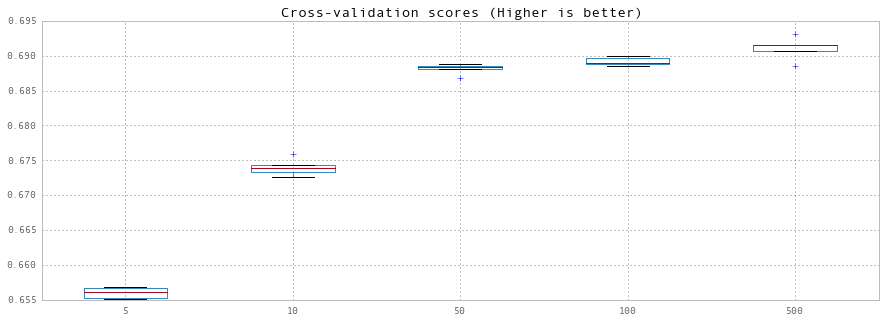

In [55]:
scores.plot(kind='box', figsize=(15, 5))
plt.title("Cross-validation scores (Higher is better)")
plt.show()

In [56]:
best_score = scores.mean(axis=0).max()
print best_score

0.691072885263


In [57]:
n_neighbors = 500
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf.fit(X, y)

x = np.array([np.arange(-5, 5, .1)]).T
pred1 = clf.predict_proba(x)

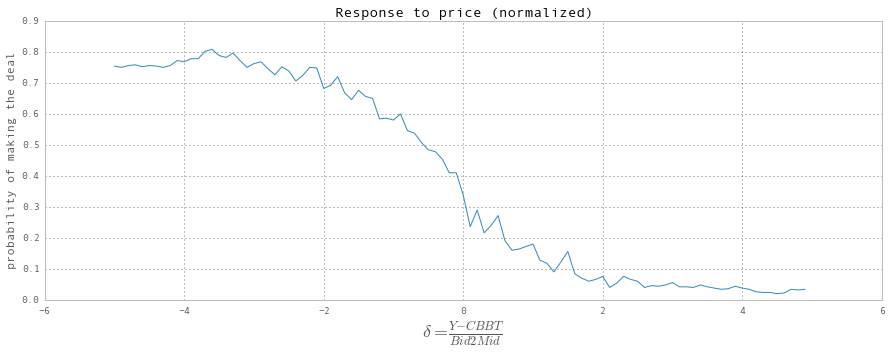

In [58]:
plt.figure(figsize=(15, 5))
plt.plot(x, pred1[:, 1])
plt.title("Response to price (normalized)")
plt.xlabel(r"$\delta = \frac{Y - CBBT}{Bid2Mid}$", size=18) 
plt.ylabel("probability of making the deal")
plt.show()

### Parametric - Logistic regression

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
L = [1e-10, 1e-5, 1e-2, 1e-1, 1, 10]

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for l in L:
    clf = LogisticRegression(penalty='l2', C=l)
    this_scores = cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=L)

[ 0.6885086   0.69088491  0.69047703  0.68978542  0.69159425]
[ 0.68898741  0.69299521  0.69118638  0.69161199  0.69173612]
[ 0.68721405  0.69120411  0.69017556  0.6906721   0.69070757]
[ 0.68730271  0.69120411  0.6902465   0.6906189   0.69070757]
[ 0.68730271  0.69118638  0.6902465   0.6906189   0.69068984]
[ 0.68730271  0.69118638  0.6902465   0.6906189   0.69068984]


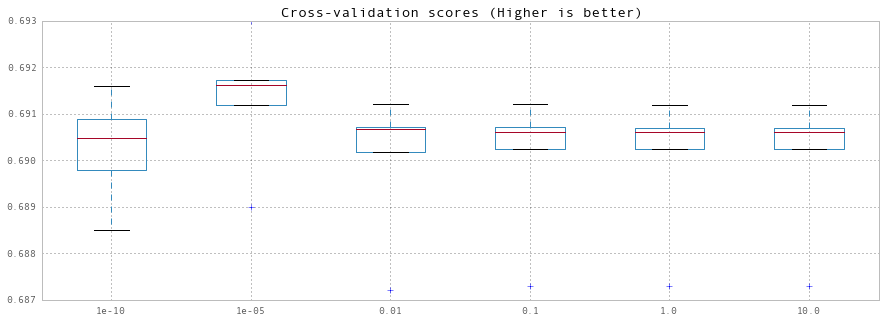

In [61]:
scores.plot(kind='box', figsize=(15, 5))
plt.title("Cross-validation scores (Higher is better)")
plt.show()

In [62]:
best_score = scores.mean(axis=0).max()
print best_score

0.691303422593


In [63]:
clf = LogisticRegression(penalty='l2', C=l)
clf.fit(X, y)

x = np.array([np.arange(-5, 5, .1)]).T
pred2 = clf.predict_proba(x)

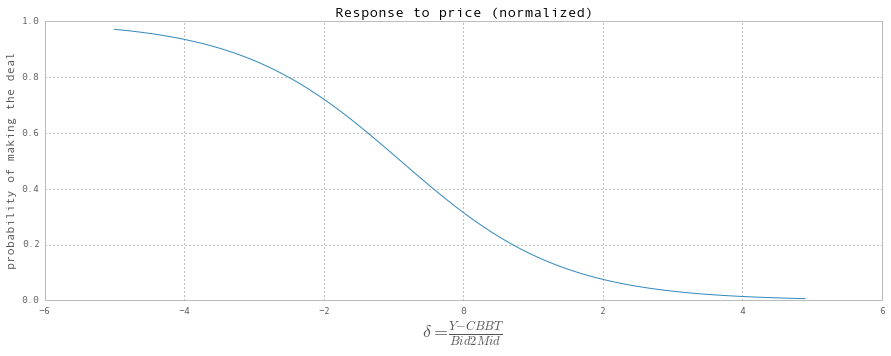

In [64]:
plt.figure(figsize=(15, 5))
plt.plot(x, pred2[:, 1])
plt.title("Response to price (normalized)")
plt.xlabel(r"$\delta = \frac{Y - CBBT}{Bid2Mid}$", size=18) 
plt.ylabel("probability of making the deal")
plt.show()

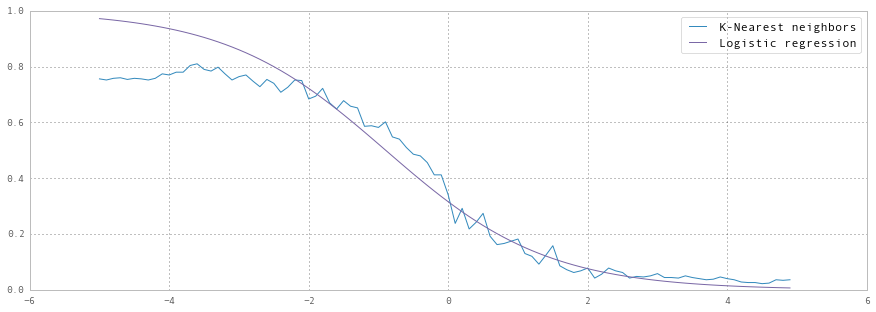

In [65]:
plt.figure(figsize=(15, 5))
plt.plot(x, np.array([pred1[:, 1], pred2[:, 1]]).T)
plt.legend(["K-Nearest neighbors", "Logistic regression", ])
plt.show()

### Adding more features

In [66]:
df.columns

Index([u'Customer', u'Sales', u'Trader', u'Trader1', u'SalesTeam', u'CustomerTrader', u'VoiceElec', u'BuySell', u'Currency', u'RFQId', u'Venue', u'RFQOrderType', u'TradeDateTime', u'InitAuditEventTimestamp', u'FinalAuditEventTimestamp', u'TradeDate', u'RFQTime', u'RFQClosedTime', u'ClientTier', u'NbDealers', u'NotionalEUR', u'NotionalUSD', u'NotionalCCY', u'StatusDetails', u'TradeStatus', u'BNPPStreamedMid', u'BNPPStreamedQuantityCcy', u'BNPPStreamedQuote', u'RFQCompositePrice', u'BNPPAnsweredQuote', u'CoverPrice', u'Bid2Mid', u'AutoNegStatus', u'Region', u'Activity', u'RiskCaptain', u'Owner', u'IsFRN', u'Ticker', u'Maturity', u'Sector', u'Rating', u'IssuerNationality', u'Seniority', u'bbgName', u'Isin', u'CDSIssuer', u'CDSSector', u'CDSSeniority', u'SalesLocation', u'TraderLocation', u'JagPositionCCY', u'StarPositionCCY', u'Benchmark', u'ANPrice', u'PV01', u'StpPortfolio', u'Bid2MidComp'], dtype='object')

In [67]:
sell = df["BuySell"] == "Sell"
buy = df["BuySell"] == "Buy"
do = df["TradeStatus"] == "Done"
ta = df["TradeStatus"] == "TradedAway"
resp = df["BNPPAnsweredQuote"] > 0
ab = df["Bid2Mid"] > 0
mat =  ~np.isnan(df['Maturity']).values
idx = buy & (do | ta) & resp & ab & mat

X = pd.DataFrame()
# Price
X["delta"] = (df.ix[idx, "BNPPAnsweredQuote"] - df.ix[idx, "RFQCompositePrice"]) / np.abs(df.ix[idx, "Bid2Mid"])
X["price"] = df.ix[idx, "BNPPAnsweredQuote"]
X["cbbt"] = df.ix[idx, "RFQCompositePrice"]
X["diff"] = df.ix[idx, "BNPPAnsweredQuote"] - df.ix[idx, "RFQCompositePrice"]
X["bid2mid"] = df.ix[idx, "Bid2Mid"]

# Dealers
X["NbDealers"] = df.ix[idx, "NbDealers"]

# Sectors
X["sectors"] = pd.Categorical(df.ix[idx, u'Sector']).codes

# RiskCaptain
X['RiskCaptain'] = pd.Categorical(df.ix[idx, 'RiskCaptain']).codes

# Notional
X['NotionalEUR'] = df.ix[idx, 'NotionalEUR']

# Rating
X['Rating'] = pd.Categorical(df.ix[idx, 'Rating']).codes

# Tickers 
X['Ticker'] = pd.Categorical(df.ix[idx, 'Ticker']).codes

# ClientTier
X['ClientTier'] = pd.Categorical(df.ix[idx, 'ClientTier']).codes

# Customer
X['Customer'] = pd.Categorical(df.ix[idx, 'Customer']).codes

# Preference
X['Preference'] = pd.Categorical(df.ix[idx, 'Customer'].map(str) + df.ix[idx, 'Ticker']).codes

# Cover Price
# X['CoverPrice'] = df.ix[idx, 'CoverPrice']

# Maturity
X['Maturity'] = pd.Categorical(df.ix[idx, 'Maturity'])

# Issuer nationality
# X['IssuerNationality'] = pd.Categorical(df.ix[idx, 'IssuerNationality'])

# Trader
X['Trader'] = pd.Categorical(df.ix[idx, 'Trader'])

y = np.array([1 if l == "Done" else 0 for l in df.ix[idx, "TradeStatus"]])

print xmin, xmax
q  = (X["delta"] > xmin) & (X["delta"] < xmax)
X = X.ix[q, :]
y = y[q.values]

-5.67566366389 5.87672519732


In [68]:
N = [5, 10, 50, 100, 500]

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for n_neighbors in N:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    this_scores = cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=N)

[ 0.63102733  0.63189629  0.6321623   0.62591995  0.63512387]
[ 0.65039281  0.65220167  0.65248541  0.65266275  0.65844402]
[ 0.65197113  0.65408147  0.65425881  0.65000266  0.6557662 ]
[ 0.64766178  0.65044601  0.64854848  0.64633173  0.65158098]
[ 0.63753569  0.63934455  0.63615244  0.63416624  0.63945096]


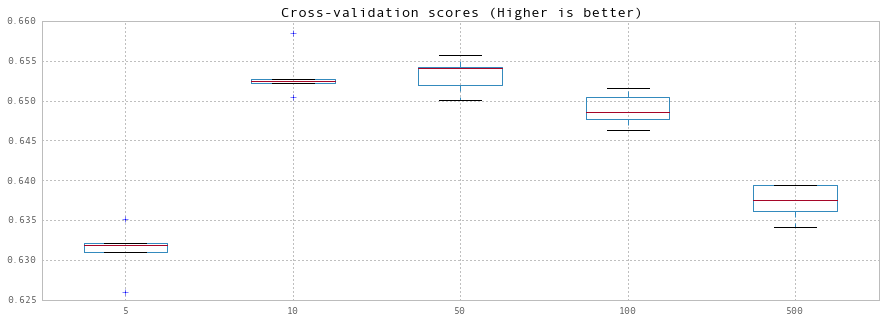

In [69]:
scores.plot(kind='box', figsize=(15, 5))
plt.title("Cross-validation scores (Higher is better)")
plt.show()

**More features is worse?!?**

In [70]:
L = [1e-10, 1e-5, 1e-2, 1e-1, 1, 10]

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for l in L:
    clf = LogisticRegression(penalty='l2', C=l)
    this_scores = cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=L)

[ 0.62983915  0.63242831  0.62964408  0.62921846  0.6332086 ]
[ 0.63092092  0.63388249  0.63070812  0.63354555  0.63572683]
[ 0.63092092  0.63482239  0.63069038  0.63019383  0.63460959]
[ 0.66571494  0.63278299  0.63069038  0.63019383  0.63462732]
[ 0.63092092  0.63278299  0.63069038  0.63019383  0.63460959]
[ 0.63092092  0.63386476  0.63069038  0.63019383  0.63444998]


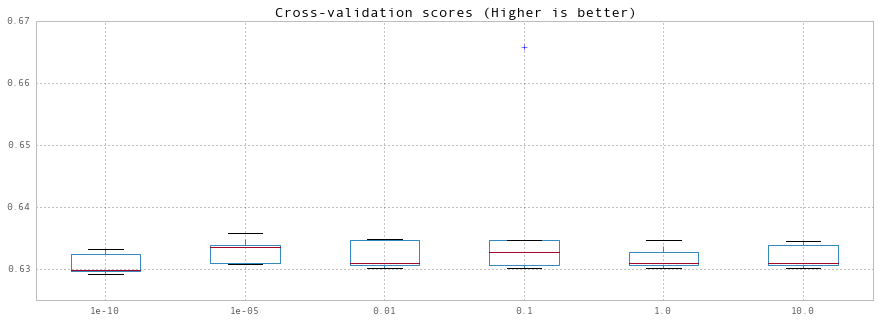

In [71]:
scores.plot(kind='box', figsize=(15, 5))
plt.title("Cross-validation scores (Higher is better)")
plt.show()

## ML for understanding - feature importance

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
N = [5, 10, 50, 100]

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for n in N:
    clf = RandomForestClassifier(n_estimators=n)
    this_scores = cross_validation.cross_val_score(clf, X.values, y, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=N)

[ 0.74656405  0.74317686  0.74445371  0.74307046  0.74555321]
[ 0.76264874  0.76403199  0.76452854  0.76243594  0.76332263]
[ 0.7757896   0.77681817  0.7747433   0.77398074  0.77543493]
[ 0.77680044  0.77875117  0.77720832  0.77660537  0.77743886]


In [74]:
best_score = scores.mean(axis=0).max()
print best_score

0.777360832787


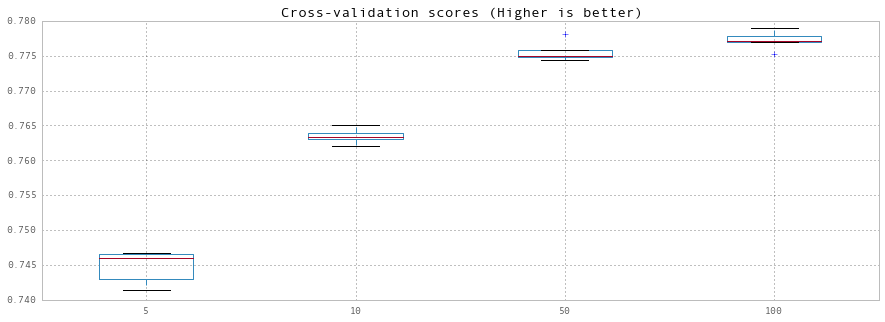

In [29]:
scores.plot(kind='box', figsize=(15, 5))
plt.title("Cross-validation scores (Higher is better)")
plt.show()

In [30]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

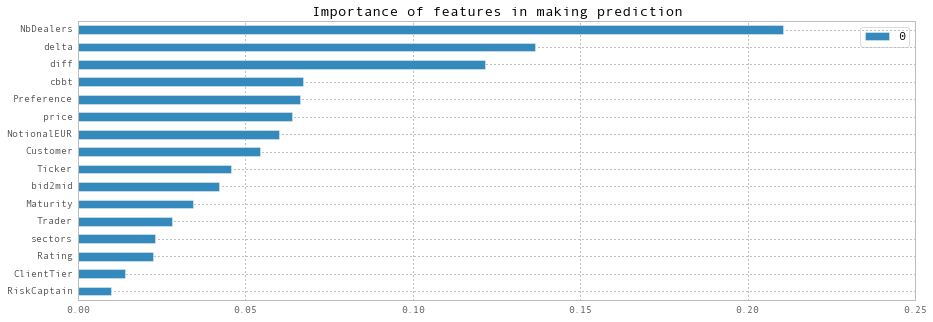

In [31]:
importance = pd.DataFrame(clf.feature_importances_, index=X.columns)
importance = importance.iloc[importance.ix[:, 0].argsort()]
importance.plot(kind='barh', figsize=(15, 5))
plt.title("Importance of features in making prediction")
plt.show()

In [32]:
pref = pd.Categorical(df.ix[idx, 'Customer'].map(str) + df.ix[idx, 'Ticker'])

In [33]:
pref

[36NDB, 2BACR, 2ACAFP, 175CAIXAB, 376LLOYDS, ..., 10MADRID, 264MADRID, 693MADRID, 264MADRID, 732MADRID]
Length: 215847
Categories (60669, object): [1000AUTODI < 1000BACARD < 1000BNSIM < 1000ISPIM ... 9VW < 9WIEAV < 9WINDIM < 9YKBNK]

In [34]:
potential = len(set(df.ix[idx, 'Customer'])) * len(set(df.ix[idx, 'Ticker']))
realized = len(set(pref))

print "potential: %s VS realized: %s" % (potential, realized)
print "ration = %.3f" % (realized / float(potential) * 100)

potential: 1516545 VS realized: 60669
ration = 4.000


In [35]:
idx_low = X['delta'] < -2.5
X_low = X.ix[idx_low, :]
y_low = y[np.array(idx_low)]
X_low.describe()

,delta,price,cbbt,diff,bid2mid,NbDealers,sectors,RiskCaptain,NotionalEUR,Rating,Ticker,ClientTier,Customer,Preference
count,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000
mean,-3.323953,103.874623,104.413421,-0.538798,0.166479,3.688241,17.247659,2.479917,441147.575284,7.840166,526.325078,1.268678,148.488866,31597.945890
std,0.753369,13.029047,12.975035,0.475050,0.141836,2.066494,12.923406,2.106615,965731.849465,3.516266,312.018955,0.761279,224.695402,17195.780586
min,-5.675030,11.000000,12.500000,-6.875000,0.001000,1.000000,-1.000000,0.000000,1000.000000,-1.000000,1.000000,0.000000,0.000000,57.000000
25%,-3.667595,99.500000,99.893219,-0.735497,0.061000,1.000000,4.000000,0.000000,100000.000000,7.000000,229.000000,1.000000,11.000000,16855.000000
50%,-3.077332,101.480000,101.893356,-0.432000,0.125000,5.000000,16.000000,3.000000,153699.773110,9.000000,506.000000,1.000000,50.000000,30293.000000
75%,-2.746745,106.500000,107.182549,-0.212000,0.250000,6.000000,32.000000,5.000000,400000.000000,11.000000,828.000000,2.000000,192.000000,47161.000000
max,-2.500000,174.000000,175.369995,-0.005333,2.500000,6.000000,37.000000,5.000000,24300000.000000,11.000000,1004.000000,2.000000,1439.000000,60668.000000


In [36]:
N = [5, 10, 50, 100, 500]

n_samples = X_low.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.3, random_state=0)

scores = []
for n in N:
    clf = RandomForestClassifier(n_estimators=n)
    this_scores = cross_validation.cross_val_score(clf, X_low.values, y_low, cv=cv, scoring='accuracy')
    print this_scores
    scores.append(this_scores)
scores = pd.DataFrame(np.array(scores).T, columns=N)

[ 0.72884882  0.72746186  0.7482663   0.73855756  0.75520111]
[ 0.72676838  0.73855756  0.74618585  0.75520111  0.73023578]
[ 0.75520111  0.74895978  0.76629681  0.76144244  0.76837725]
[ 0.75866852  0.75104022  0.76768377  0.76837725  0.76352288]
[ 0.76421637  0.75381415  0.76907074  0.7739251   0.77253814]


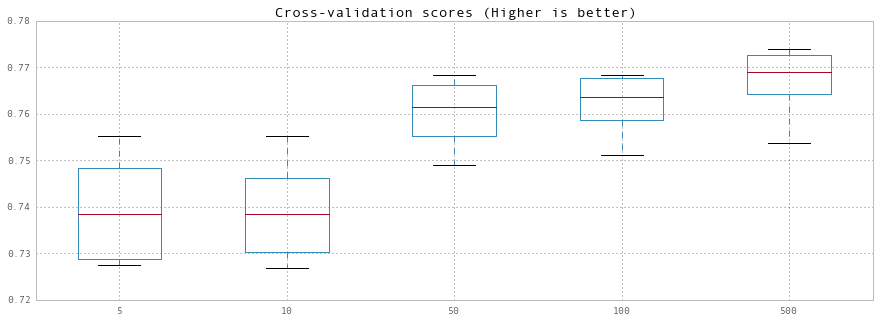

In [44]:
scores.plot(kind='box', figsize=(15, 5))
plt.title("Cross-validation scores (Higher is better)")
plt.show()

In [45]:
best_score = scores.mean(axis=0).max()
print best_score

0.766712898752


In [38]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_low.values, y_low)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

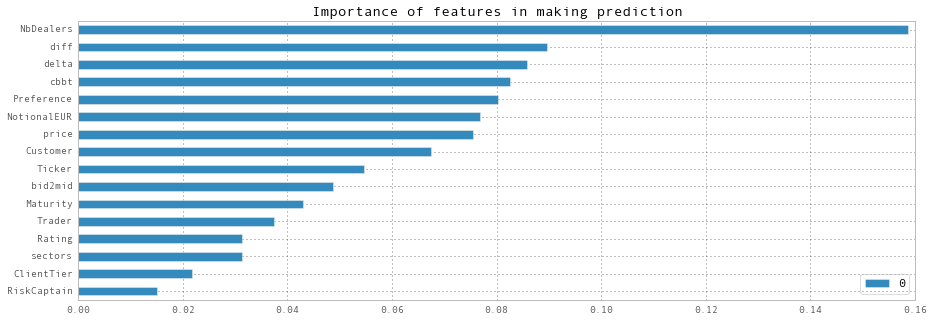

In [39]:
importance = pd.DataFrame(clf.feature_importances_, index=X_low.columns)
importance = importance.iloc[importance.ix[:, 0].argsort()]
importance.plot(kind='barh', figsize=(15, 5))
plt.title("Importance of features in making prediction")
plt.show()

In [40]:
df.columns

Index([u'Customer', u'Sales', u'Trader', u'Trader1', u'SalesTeam', u'CustomerTrader', u'VoiceElec', u'BuySell', u'Currency', u'RFQId', u'Venue', u'RFQOrderType', u'TradeDateTime', u'InitAuditEventTimestamp', u'FinalAuditEventTimestamp', u'TradeDate', u'RFQTime', u'RFQClosedTime', u'ClientTier', u'NbDealers', u'NotionalEUR', u'NotionalUSD', u'NotionalCCY', u'StatusDetails', u'TradeStatus', u'BNPPStreamedMid', u'BNPPStreamedQuantityCcy', u'BNPPStreamedQuote', u'RFQCompositePrice', u'BNPPAnsweredQuote', u'CoverPrice', u'Bid2Mid', u'AutoNegStatus', u'Region', u'Activity', u'RiskCaptain', u'Owner', u'IsFRN', u'Ticker', u'Maturity', u'Sector', u'Rating', u'IssuerNationality', u'Seniority', u'bbgName', u'Isin', u'CDSIssuer', u'CDSSector', u'CDSSeniority', u'SalesLocation', u'TraderLocation', u'JagPositionCCY', u'StarPositionCCY', u'Benchmark', u'ANPrice', u'PV01', u'StpPortfolio', u'Bid2MidComp'], dtype='object')

In [41]:
X['Maturity'].describe()

count     187963
unique        42
top            4
freq       29027
Name: Maturity, dtype: float64

In [42]:
X['Maturity'].unique()

array([ -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  34.,  35.,  36.,  40.,  42.,  45.,  46.,  99.])

In [43]:
np.isnan(df['Maturity']).values

array([False, False, False, ..., False, False, False], dtype=bool)